# Exercise 3 - Anderson model on RRG

In [1]:
from pathlib import Path
from functools import partial
import itertools

import numpy as np
import networkx as nx
import scipy.sparse
from tqdm.notebook import tqdm as tqdm_
import tqdm.contrib.concurrent

import matplotlib.pyplot as plt

import disordered_sys.anderson

/net/theorie/home/heikogeorg.menzler/projects/acpl-cavity_method/code/disordered_sys/anderson.py:21: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(conn_graph)


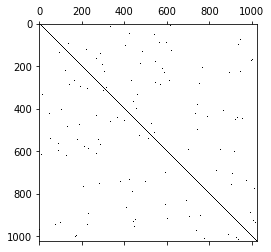

In [2]:
# make experiments reproducible
np.random.seed(42)

c = 3
w = .3
size = 2**10
g = disordered_sys.anderson.graph(conn=c, size=size)
h = disordered_sys.anderson.hamiltonian(g, w=w)

figure_dir = Path.cwd() / ".." / "report" / "figures"
plt.rcParams['figure.dpi'] = 159
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 18

plt.spy(h)
plt.show()

# Spectrum from direct diagonalization

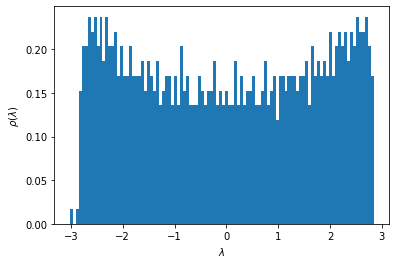

In [3]:
vals = np.linalg.eigvalsh(h)
plt.hist(vals, stacked=True, density=True, bins=size // 10)
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho(\\lambda)$")
plt.savefig(figure_dir / "ex3_spectrum_exact_diag.pdf")

# Spectrum from cavity method

In [4]:
tol = 1e-4
max_steps = 100

def get_neighbors(g, k, j=-1):
    neighbors_set = set(g.neighbors(k)) - {j}
    return np.array(list(neighbors_set))

def cavity_equation(h, g, cav_precs, lam, k, j=-1):
    n_idxs = get_neighbors(g, k, j)
    e_weight = h[k, k]
    prec_weights = cav_precs[k, n_idxs].todense()

    return 1j * (-1j * epsilon + lam - e_weight) + np.sum(1 / prec_weights)

def init_cavity_precs(g):
    cavity_init = np.random.uniform(size=len(g.edges) * 2) + 1j * np.random.uniform(size=len(g.edges) * 2)
    adj_mat = nx.to_scipy_sparse_array(g, nodelist=sorted(list(g.nodes())))
    cavity_init = adj_mat[adj_mat.nonzero()] * cavity_init
    cavity_precs = scipy.sparse.coo_matrix((cavity_init, adj_mat.nonzero()))
    cavity_precs = cavity_precs.tocsr(copy=False)
    return cavity_precs

def spectral_density(lam):
    cavity_precs = init_cavity_precs(g)

    delta = np.inf
    steps = 0
    while delta > tol and steps < max_steps:
        reference = cavity_precs.copy()
        for k, j in g.to_directed().edges:
            cavity_precs[j, k] = cavity_equation(h, g, cavity_precs, lam, k, j)
        delta = np.max(np.abs(cavity_precs - reference))
        steps += 1


    marginals = np.mean(cavity_precs, axis=1)  # type: ignore

    delta = np.inf
    steps = 0
    while delta > tol and steps < max_steps:
        reference = marginals.copy()
        for k in g.nodes:
            marginals[k] = cavity_equation(h, g, cavity_precs, lam, k)
        delta = np.max(np.abs(marginals - reference))
        steps += 1
    
    G_ii = 1j / marginals
    rho_lambda = G_ii.imag.mean() / np.pi
    return rho_lambda

In [5]:
epsilon = 1e-3
lambdas = np.linspace(-4, 4, num=50)
spectrum = tqdm.contrib.concurrent.process_map(spectral_density, lambdas)

  0%|          | 0/50 [00:00<?, ?it/s]

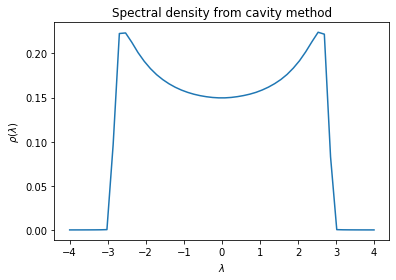

In [6]:
plt.plot(lambdas, spectrum)
plt.title("Spectral density from cavity method")
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho(\\lambda)$")
plt.savefig(figure_dir / "ex3_spectrum_cavity.pdf")

# Spectrum from population method

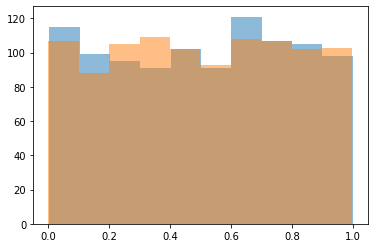

In [7]:
def init_pop_marginals(n):
    pop_init = np.random.uniform(size=n) + 1j * np.random.uniform(size=n)
    return pop_init

def population_equation(pop, lam, w):
    energy = np.random.uniform(low=-w/2, high=w/2)
    return 1j * (lam - 1j * epsilon - energy) + np.sum(1 / pop)


example_init = init_pop_marginals(len(g.nodes))
plt.hist(example_init.real, alpha=.5)
plt.hist(example_init.imag, alpha=.5)
plt.savefig(figure_dir / "ex3_pop_init_distribution_example.pdf")

In [8]:
n_p = 1_000
tol = 1e-3
epsilon = 1e-3
max_sweeps = 200

def spectral_density_pop(lam=0, n_p=n_p, w=w, return_g=False, return_G=False):
    population = init_pop_marginals(n_p)

    delta = np.inf
    steps = 0
    reference = population.mean()
    while delta > tol and steps < max_sweeps:
        
        for _ in range(n_p):    
            target = np.random.randint(low=0, high=n_p)
            pop_indices = np.random.randint(low=0, high=n_p, size=c-1)
            population[target] = population_equation(population[pop_indices], lam, w)
        
        delta = np.abs(- reference + (reference:=population.mean()))
        steps += 1
                                              
    marginals = np.zeros(size, dtype=np.complex64)
    for target_marg in range(size):
        pop_indices = np.random.randint(low=0, high=n_p, size=c)
        marginals[target_marg] = population_equation(population[pop_indices], lam, w)
        
        target_pop = np.random.randint(low=0, high=n_p)
        pop_indices = np.random.randint(low=0, high=n_p, size=c-1)
        population[target_pop] = population_equation(population[pop_indices], lam, w)
        
    G_ii = 1j / marginals
    rho_lambda = G_ii.imag.mean() / np.pi
    
    if return_g: return 1j / population
    if return_G: return G_ii
    return rho_lambda

  0%|          | 0/50 [00:00<?, ?it/s]

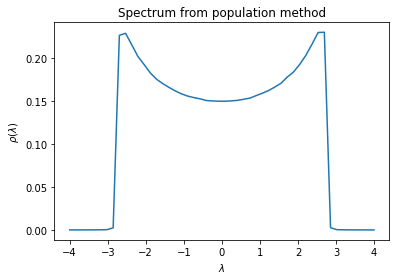

In [9]:
lambdas = np.linspace(-4, 4, num=50)
spectrum = tqdm.contrib.concurrent.process_map(spectral_density_pop, lambdas)
plt.plot(lambdas, spectrum)
plt.title("Spectrum from population method")
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho(\\lambda)$")
plt.savefig(figure_dir / "ex3_spectrum_population.pdf")

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

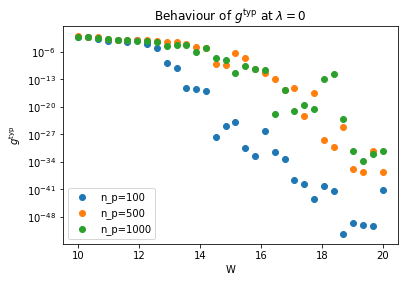

In [10]:
n_ps = [100, 500, 1_000]
lam = 0
epsilon = 1e-300
ws = np.linspace(10, 20, num=32)  # i got 32 cpus lol
for n_p in n_ps:
    g_typ_exp = partial(spectral_density_pop, lam, n_p, return_g=True)
    g_dist = tqdm.contrib.concurrent.process_map(g_typ_exp, ws)
    g_typ = map(lambda gs: np.exp(np.log(gs.imag).mean()), g_dist)
    plt.scatter(ws, list(g_typ), label=f"{n_p=}")

    
plt.yscale("log")
plt.legend()
plt.ylabel("$g^{\\mathrm{typ}}$")
plt.xlabel("W")
plt.title("Behaviour of $g^{\\mathrm{typ}}$ at $\\lambda=0$")
plt.savefig(figure_dir / "ex3_population_method_scaling.pdf")

In [11]:
n_p = 1_000
lam = 0
ws = [2, 20]
epsilon = 1e-6

G_typ_exp = partial(spectral_density_pop, lam, n_p, return_G=True)
extended, localized = tqdm.contrib.concurrent.process_map(G_typ_exp, ws)

  0%|          | 0/2 [00:00<?, ?it/s]

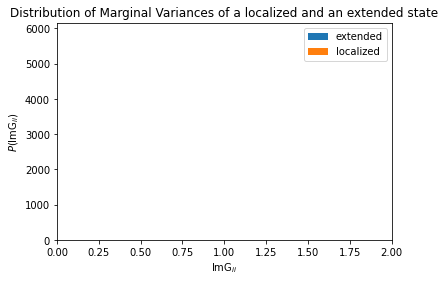

In [12]:
plt.hist(extended.imag, density=True, stacked=True, bins=size // 2, label="extended")
plt.hist(localized.imag, density=True, stacked=True, bins=size // 2, label="localized")
plt.xlabel("$\\mathrm{Im}\\mathrm{G}_{i i}$")
plt.ylabel("$P(\\mathrm{Im}\\mathrm{G}_{i i})$")
plt.xlim(0, 2)
plt.title("Distribution of Marginal Variances of a localized and an extended state")
plt.legend()
plt.savefig(figure_dir / "ex3_typical_marginal_dists.pdf")

In [14]:
np.random.seed(42)
sizes = [2 ** 10, 2 ** 11, 2 ** 12]
eps_env = .15
ws = np.linspace(5, 10, num=10)

def inverse_participation_ratio(vec, axis=-1):
    to_the_fourth = vec * vec * vec * vec
    squared = vec * vec
    return np.sum(to_the_fourth, axis=axis) / np.sum(squared, axis=axis)

exp_results = {}
for w, size in tqdm_(itertools.product(ws, sizes), total=3 * 10):  # cannot paralleize this :(
    g = disordered_sys.anderson.graph(conn=c, size=size)
    h = disordered_sys.anderson.hamiltonian(g, w=w)
    
    vals, vecs = np.linalg.eigh(h)
    
    env_mask = np.logical_and(-eps_env < vals, vals < eps_env)
    vecs_in_env = np.array(vecs[env_mask]) 
    
    assert vecs_in_env.shape[0] >= 10, "Not using enough vectors, increse epsilon environment size"
    
    mean_ipr = inverse_participation_ratio(vecs_in_env).mean() * size
    exp_results[w, size] = mean_ipr

  0%|          | 0/30 [00:00<?, ?it/s]

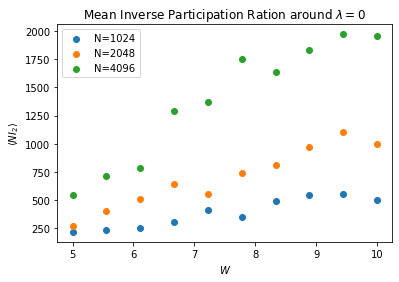

In [15]:
small = [exp_results[w, sizes[0]] for w in ws]
med = [exp_results[w, sizes[1]] for w in ws]
big = [exp_results[w, sizes[2]] for w in ws]

plt.scatter(ws, small, label=f"N={sizes[0]}")
plt.scatter(ws, med, label=f"N={sizes[1]}")
plt.scatter(ws, big, label=f"N={sizes[2]}")
plt.legend()
plt.title("Mean Inverse Participation Ration around $\\lambda = 0$")
plt.xlabel("$W$")
plt.ylabel("$\\langle N I_2\\rangle$")
plt.savefig(figure_dir / "ex3_inverse_particitpation_ratio.pdf")